In [181]:
import os
import pandas as pd
import qiime2 as q2
from biom import Table, load_table
from qiime2 import Artifact
from qiime2 import Metadata
import numpy as np
import random

from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import phylogenetic_rpca_with_taxonomy
from qiime2.plugins.empress.actions import (community_plot, tree_plot)
from qiime2.plugins.qurro.actions import loading_plot
from qiime2.plugins.phylogeny.methods import filter_table

np.random.seed(42)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [262]:
# import data
table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                load_table('../../data/Westernization-Qiita-10333/urbmerged.biom'))
metadata = q2.Metadata.load('../../data/Westernization-Qiita-10333/10333_20190808-130957.txt')
tree = q2.Artifact.load('../../data/Westernization-Qiita-10333/sepp-tree/tree.qza')
table = filter_table(table, tree).filtered_table
#taxonomy = q2.Artifact.load('../../data/Westernization-Qiita-10333/taxonomy.qza')

# remove controls
mf = metadata.to_dataframe()
mf = mf[mf.host_body_site == 'UBERON:skin of hand']
#mf = mf[mf.host_body_site == 'UBERON:feces']
mf = mf[mf.house_number.isin([k for k, v in mf.house_number.value_counts().items()
                              if v >= 3])]

# keep shared IDs
bt = table.view(Table)
shared_ = set(bt.ids()) & set(mf.index)
bt = bt.filter(shared_)

# filter out zero sums
n_features, n_samples = bt.shape
# filter features by N samples presence
min_feature_frequency = 0
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
min_feature_count = 10
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
#bt = bt.filter(bt.ids('observation')[(bt.sum('observation') > 0)], axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > 0)])
mf = mf.reindex(bt.ids())
metadata = q2.Metadata(mf)

# re-import
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
bt

15578 x 197 <class 'biom.table.Table'> with 138752 nonzero entries (4% dense)

In [263]:
# import data
#table = q2.Artifact.load('../../results/Westernization-Qiita-10333-results/filtered-input-table.qza')
#tree = q2.Artifact.load('../../data/Westernization-Qiita-10333/sepp-tree/tree.qza')
#mf = pd.read_csv('../../results/Westernization-Qiita-10333-results/filtered-input-metadata.tsv', sep='\t', index_col=0)

mf.index.name = '#SampleID'
q2mf = q2.Metadata(mf.drop(['dna_extracted','dryer','wireless','fans',
                            'kitchen_exhaust','washer',
                            'physical_specimen_remaining','public','swimming_pool'], axis=1))
taxonomy = q2.Artifact.load('../../data/Westernization-Qiita-10333/taxonomy.qza')
taxonomy_df = taxonomy_df.loc[['k__Archaea' not in v for v in taxonomy_df.Taxon], :]
taxonomy_df = taxonomy_df.loc[['p__Cyanobacteria' not in v for v in taxonomy_df.Taxon], :]
taxonomy = q2.Metadata(taxonomy_df)


In [264]:
# run phylo RPCA
phylo_rpca_res = phylogenetic_rpca_with_taxonomy(table, tree, taxonomy, min_feature_frequency=25)

# save results
phylo_rpca_res.biplot.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/biplot.qza')
phylo_rpca_res.distance_matrix.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/distance_matrix.qza')
phylo_rpca_res.counts_by_node_tree.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/counts_by_node_tree.qza')
phylo_rpca_res.counts_by_node.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/counts_by_node.qza')
phylo_rpca_res.t2t_taxonomy.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/t2t_taxonomy.qza')
q2.Metadata(mf.drop(['dna_extracted','dryer','wireless','fans','kitchen_exhaust','washer','physical_specimen_remaining','public','swimming_pool'], axis=1)).save('../../results/Westernization-Qiita-10333-results/metadata.qza')



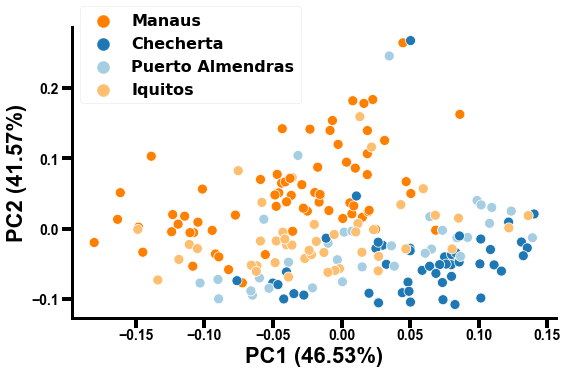

In [265]:
catagory = 'village'
pal_use = {'Checherta':'#1f78b4',
           'Iquitos':'#fdbf6f',
           'Puerto Almendras':'#a6cee3',
           'Manaus':'#ff7f00'}


fig, ax = plt.subplots(1, 1,figsize=(8, 5))


ord_tmp = phylo_rpca_res.biplot.view(OrdinationResults).samples[[0, 1, 2]].copy()
mf_tmp = mf.copy().reindex(ord_tmp.index)
ord_tmp = pd.concat([ord_tmp, mf_tmp[list(set([catagory, 'house_number']))]],
                    axis=1, sort=False).dropna(subset=[0, catagory])
ord_tmp[catagory] = ord_tmp[catagory].astype(str)
ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']

sns.scatterplot(x=0, y=1, hue=catagory,s=100,
                data=ord_tmp, ax=ax, palette=pal_use)
ax.legend_.remove()


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)

for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(14)
ax.set_ylabel('PC2 (%.2f%%)' % (phylo_rpca_res.biplot.view(OrdinationResults).proportion_explained[1] * 100 ),
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_xlabel('PC1 (%.2f%%)' % (phylo_rpca_res.biplot.view(OrdinationResults).proportion_explained[0] * 100 ),
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')

plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], labels[1:],
          loc=2, bbox_to_anchor=(0.0, 1.1),
          prop={'size':16},
          fancybox=True, framealpha=0.5, 
          ncol=1, markerscale=2,
          facecolor="white")


plt.savefig('../../results/figures/westernization-scatterplots-single.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


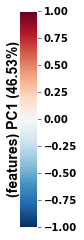

In [196]:
a = np.array([[-1, 1]])
plt.figure(figsize=(5, 30))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
bar_list = list(np.linspace(-.1, .1, 5).round(2))
bar_list.remove(0)
cax = plt.axes(bar_list)
color_bar = plt.colorbar(cax=cax)
color_bar.set_label('(features) PC1 (%.2f%%)' % (phylo_rpca_res.biplot.view(OrdinationResults).proportion_explained[0] * 100 ),
              fontsize=14,
              family = 'arial',
              weight='bold',
                    labelpad=-70,
              color='black')
#color_bar.outline.set_edgecolor('gray')
color_bar.ax.yaxis.set_tick_params(labelcolor='black', labelsize=10)

plt.savefig('../../results/figures/west-colorbar.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()



In [198]:
from sklearn.preprocessing import StandardScaler

# add loadings to feature metadata for tree plotting
feature_loadings = phylo_rpca_res.biplot.view(OrdinationResults).features
#feature_loadings[feature_loadings.columns] = StandardScaler().fit_transform(feature_loadings)
feature_loadings -= feature_loadings.mean(0)
feature_loadings.columns = ["PC%i (%.2f%%)" % (i + 1, pc_i * 100)
                            for i, pc_i in enumerate(phylo_rpca_res.biplot.view(OrdinationResults).proportion_explained)]

t2t_taxonomy_df = phylo_rpca_res.t2t_taxonomy.view(q2.Metadata).to_dataframe()
t2t_taxonomy_loadings_df = pd.concat([feature_loadings, t2t_taxonomy_df], axis=1)
t2t_taxonomy_loadings_df.index.name = "featureid"
t2t_taxonomy_loadings = q2.Metadata(t2t_taxonomy_loadings_df)


In [199]:
t2t_taxonomy_loadings.to_dataframe().to_csv('../../results/Compare-Datasets/cross-sectional-feature-loadings.tsv', sep='\t')
phylo_rpca_res.counts_by_node_tree.save('../../results/Compare-Datasets/cross-sectional-tree.qza')


'../../results/Compare-Datasets/cross-sectional-tree.qza'

In [200]:

empress_cp_res = community_plot(phylo_rpca_res.counts_by_node_tree,
                                phylo_rpca_res.counts_by_node,
                                q2mf,
                                pcoa = phylo_rpca_res.biplot,
                                feature_metadata = t2t_taxonomy_loadings,
                                number_of_features = 100,
                                ignore_missing_samples = True,
                                filter_missing_features = True,
                                filter_extra_samples = True)
empress_cp_res.visualization.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/empress_cp.qzv')


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/empress/tools.py:242: DataMatchingWarning: 474 feature(s) in the table were not present as tips in the tree. These feature(s) have been removed from the visualization.
  DataMatchingWarning


'../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/empress_cp.qzv'

In [201]:
qurro_res = loading_plot(phylo_rpca_res.biplot, phylo_rpca_res.counts_by_node, q2mf, feature_metadata = t2t_taxonomy_loadings)
qurro_res.visualization.save('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/qurro.qzv')


'../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/qurro.qzv'

In [202]:
lr_mf = pd.read_csv('../../results/Westernization-Qiita-10333-results/phylogenetic-rpca/sample_plot_data_proteo.tsv', sep='\t', index_col=0)
lr_mf = pd.concat([lr_mf.drop(['village'], axis=1), mf], axis=1)
lr_mf.head(3)


,Current_Natural_Log_Ratio,village.1,ac_sampled_room,accult_score,analysis_name,animals_in_house,anonymized_name,carbon_dioxide_inside,cats,cleaning_frequency,...,temp_outside_house,title,use_soaps,village,washer,water_source,wind_speed_outside,wireless,years_house_inhabited,zone
10333.Che.103.huma,2.516260,Checherta,FALSE,0,Che.103.huma,1,MG.0006,449,0,0,...,28,Dominguez Sloan SAWesternization gradient,NaN,Checherta,FALSE,spring,0.54,FALSE,17,Checherta
10333.Che.109.huma,NaN,NaN,FALSE,0,Che.109.huma,1,MG.0012,449,0,0,...,28,Dominguez Sloan SAWesternization gradient,NaN,Checherta,FALSE,spring,0.54,FALSE,17,Checherta
10333.Che.114.huma,0.932448,Checherta,FALSE,0,Che.114.huma,1,MG.0018,449,0,0,...,28,Dominguez Sloan SAWesternization gradient,NaN,Checherta,FALSE,spring,0.54,FALSE,17,Checherta


In [226]:
table_filt_df = phylo_rpca_res.counts_by_node.view(Table).to_dataframe() + 0
num = table_filt_df.loc[['n697'], :].sum(0)
# n501
den = table_filt_df.loc[['n910'], :].sum(0)
# n3675, n3673, n3685, n2888
lr = np.log(num) - np.log(den)
lr[~np.isfinite(lr)]= np.nan

mf_lr = mf.copy()
mf_lr = mf_lr.reindex(table_filt_df.columns)
mf_lr['log_ratio'] = lr


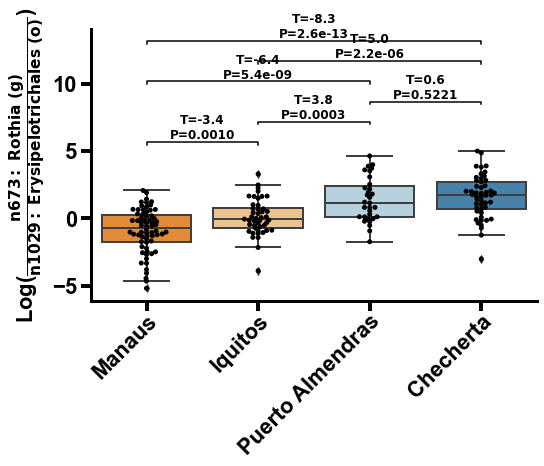

In [227]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

from scipy.stats import ttest_ind
pal_ = {'Checherta':'#1f78b4',
           'Iquitos':'#fdbf6f',
           'Puerto Almendras':'#a6cee3',
           'Manaus':'#ff7f00'}

label_ = 'Log($\\frac{\mathrm{n673:\,\,Rothia\,\,(g)}}{\mathrm{n1029:\,\,Erysipelotrichales\,\,(o)}}$)'

fig, ax = plt.subplots(1,1, figsize=(8, 5))

y_ = 'log_ratio'
order_map = {'Checherta':3, 'Puerto Almendras':2, 'Iquitos':1, 'Manaus':0}
order_ = ['Manaus', 'Iquitos', 'Puerto Almendras', 'Checherta']
lrdf_plot = mf_lr.dropna(subset=[y_]).copy()

t_res = {}
lrs_ds = {ds_:dsdf_[y_].values for ds_, dsdf_ in lrdf_plot.groupby('village')}
comobos = [('Manaus', 'Iquitos'), ('Puerto Almendras', 'Iquitos'), ('Checherta', 'Puerto Almendras'),
           ('Manaus', 'Puerto Almendras'), ('Checherta', 'Iquitos'), ('Manaus','Checherta')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='village', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='village', 
              data=lrdf_plot,
              palette=pal_,
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
#ax.set_ylim(-6, 10)
#ax.spines['left'].set_bounds(-5, 10)

ax.set_ylabel(label_,
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_xlabel('',
              fontsize=18,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    #max_ = []
    #vals_ = [v[y_].dropna().values for k,v in lrdf_plot.groupby('disease_severity')]
    #stat_, p_ = ttest_ind(vals_[0], vals_[1])
    #x1, x2 = 0, 1
    #y, h, col = lrdf_plot[y_].max() + 0.5, .25, 'k'
    y, h, col = (i_v  * 1.5) + 5.5, .2, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        #p_ = "N=%i\nT=%.1f\nP=%s" % (lrdf_plot.shape[0],stat_,p_)
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        #p_ = "N=%i\nT=%.1f\nP=%.4f" % (lrdf_plot.shape[0],stat_,p_)
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2)*.5, y+h,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

plt.savefig('../../results/figures/log-ratio-westernization-scatterplots-single.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [140]:
table_filt_df = phylo_rpca_res.counts_by_node.view(Table).to_dataframe() + 0
num = table_filt_df.loc[['n491'], :].sum(0)
# n501
den = table_filt_df.loc[['n1029'], :].sum(0)
# n3675, n3673, n3685, n2888
lr = np.log(num) - np.log(den)
lr[~np.isfinite(lr)]= np.nan

mf_lr = mf.copy()
mf_lr = mf_lr.reindex(table_filt_df.columns)
mf_lr['log_ratio'] = lr


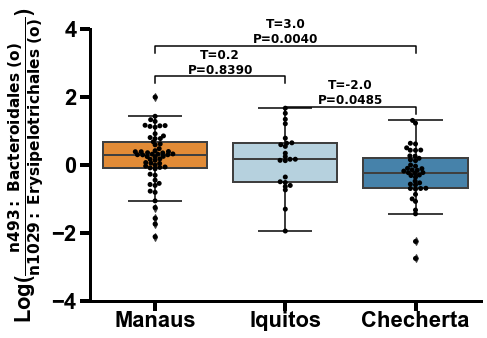

In [158]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

from scipy.stats import ttest_ind

Checherta from Iquitos and Manaus - but not Iquitos from Manaus.

pal_ = {'Checherta':'#1f78b4', 'Iquitos':'#a6cee3', 'Manaus':'#ff7f00'}
label_ = 'Log($\\frac{\mathrm{n493:\,\,Bacteroidales\,\,(o)}}{\mathrm{n1029:\,\,Erysipelotrichales\,\,(o)}}$)'

fig, ax = plt.subplots(1,1, figsize=(7, 5))

y_ = 'log_ratio'
order_map = {'Checherta':2, 'Iquitos':1, 'Manaus':0}
order_ = ['Manaus', 'Iquitos', 'Checherta']
lrdf_plot = mf_lr.dropna(subset=[y_]).copy()

t_res = {}
lrs_ds = {ds_:dsdf_[y_].values for ds_, dsdf_ in lrdf_plot.groupby('village')}
comobos = [('Checherta', 'Iquitos'), ('Manaus', 'Iquitos'), ('Manaus','Checherta')]
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x='village', 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='village', 
              data=lrdf_plot,
              palette=pal_,
              order=order_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
"""ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")"""
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    #tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
ax.set_ylim(-4, 4)
ax.spines['left'].set_bounds(-4, 4)

ax.set_ylabel(label_,
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_xlabel('',
              fontsize=18,
              family = 'arial',
              weight='bold',
              color='black')


for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    #max_ = []
    #vals_ = [v[y_].dropna().values for k,v in lrdf_plot.groupby('disease_severity')]
    #stat_, p_ = ttest_ind(vals_[0], vals_[1])
    #x1, x2 = 0, 1
    #y, h, col = lrdf_plot[y_].max() + 0.5, .25, 'k'
    y, h, col = (i_v  * 0.9) + 1.5, .2, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        #p_ = "N=%i\nT=%.1f\nP=%s" % (lrdf_plot.shape[0],stat_,p_)
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        #p_ = "N=%i\nT=%.1f\nP=%.4f" % (lrdf_plot.shape[0],stat_,p_)
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2)*.5, y+h,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)

plt.savefig('../../results/figures/log-ratio-westernization-bithmode-scatterplots-single.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [160]:
mf_lr.columns

Index(['ac_sampled_room', 'accult_score', 'analysis_name', 'animals_in_house',
       'anonymized_name', 'carbon_dioxide_inside', 'cats',
       'cleaning_frequency', 'closed_trash', 'collection_date',
       'collection_timestamp', 'country', 'description', 'diet',
       'direct_intestinal_parasites', 'dna_extracted', 'dogs', 'dominant_hand',
       'dryer', 'elevation', 'env_biome', 'env_feature', 'env_material',
       'env_package', 'ethnicity', 'fans', 'foot_ware', 'geo_loc_name',
       'health_stat', 'height_or_length', 'host_age', 'host_age_units',
       'host_body_habitat', 'host_body_product', 'host_body_site',
       'host_common_name', 'host_subject_id', 'host_taxid', 'host_weight',
       'host_weight_units', 'hours_house_empty_day', 'hours_house_empty_night',
       'house_number', 'humidity_percent', 'intestinal_parasites_khato',
       'kitchen_exhaust', 'last_day_using_antibiotics', 'latitude',
       'light_exposure', 'light_lux_inside', 'longitude', 'material',
   

In [3]:
bt_table_emp500 = load_table('/Users/cmartino/Dropbox/bin/COVID19-hosp/preprocessedData/emp150_merged.biom')
tree_emp500 = q2.Artifact.load('/Users/cmartino/Dropbox/bin/COVID19-hosp/preprocessedData/sepp_merged_tree.qza')
tax_emp500 = q2.Artifact.load('/Users/cmartino/Dropbox/bin/COVID19-hosp/preprocessedData/gg_taxonomy.qza').view(q2.Metadata).to_dataframe()

# filter and match the table
n_features, n_samples = bt_table_emp500.shape
min_feature_frequency = 10
min_feature_count = 10
min_sample_count = 1000
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt_table_emp500 = bt_table_emp500.filter(observation_filter, axis='observation')
bt_table_emp500 = bt_table_emp500.filter(frequency_filter, axis='observation')
bt_table_emp500 = bt_table_emp500.filter(bt.ids()[(bt_table_emp500.sum('sample') > min_sample_count)])

# build LCA and expand table
tree_emp500_tn = tree_emp500.view(TreeNode)
counts_by_node_emp, tree_index_emp, branch_lengths_emp, fids_emp, otu_ids_emp = fast_unifrac(bt_table_emp500,
                                                                                             tree_emp500_tn)
traversed_taxonomy_emp500 = retrieve_t2t_taxonomy(tree_emp500_tn, tax_emp500)
traversed_taxonomy_emp500_df = create_taxonomy_metadata(tree_emp500_tn, traversed_taxonomy_emp500)

# take LR based on LCA
num_lca_node = traversed_taxonomy_emp500_df.iloc[['c__Alphaproteobacteria' in t for t in traversed_taxonomy_emp500_df.Taxon].index(True)].name 
denom_lca_node = traversed_taxonomy_emp500_df.iloc[['c__Betaproteobacteria' in t for t in traversed_taxonomy_emp500_df.Taxon].index(True)].name 
lr = np.log(counts_by_node_emp[:, fids_emp.index(num_lca_node.lower())]) -  np.log(counts_by_node_emp[:, fids_emp.index(denom_lca_node.lower())])  
lr[~np.isfinite(lr)] = np.nan


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-e31c4db6eea5>", line 14, in <module>
    bt_table_emp500 = bt_table_emp500.filter(observation_filter, axis='observation')
  File "/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/biom/table.py", line 2241, in filter
    invert=invert)
  File "biom/_filter.pyx", line 132, in biom._filter._filter
  File "biom/_filter.pyx", line 56, in biom._filter._make_filter_array_general
  File "<ipython-input-3-e31c4db6eea5>", line 13, in observation_filter
    return sum(val) > min_feature_count
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.

KeyboardInterrupt: 

In [ ]:
bt_table_emp500

In [ ]:
# add lr to metadata
metadata_emp500 = pd.read_csv('/Users/cmartino/Dropbox/bin/COVID19-hosp/preprocessedData/emp150.txt', sep='\t', index_col=0)
metadata_emp500 = metadata_emp500.reindex(bt_table_emp500.ids())
metadata_emp500['log_ratio'] = lr


In [306]:
from gemelli.preprocessing import retrieve_t2t_taxonomy, create_taxonomy_metadata, fast_unifrac

# import data
table_emp500 = q2.Artifact.load('../../data/EMP2/emp500_woltka_classify_norm_10perc_min6550.qza')
tree_emp500 = q2.Artifact.load('../../data/EMP2/wol_tree.qza')
tax_emp500 = q2.Artifact.load('../../data/EMP2/wol_taxonomy.qza').view(q2.Metadata).to_dataframe()
bt_table_emp500 = table_emp500.view(Table)

# build LCA and expand table
tree_emp500_tn = tree_emp500.view(TreeNode)
counts_by_node_emp, tree_index_emp, branch_lengths_emp, fids_emp, otu_ids_emp = fast_unifrac(bt_table_emp500,
                                                                                             tree_emp500_tn)
traversed_taxonomy_emp500 = retrieve_t2t_taxonomy(tree_emp500_tn, tax_emp500)
traversed_taxonomy_emp500_df = create_taxonomy_metadata(tree_emp500_tn, traversed_taxonomy_emp500)

# take LR based on LCA
num_lca_node = traversed_taxonomy_emp500_df.iloc[['c__Alphaproteobacteria' in t for t in traversed_taxonomy_emp500_df.Taxon].index(True)].name 
denom_lca_node = traversed_taxonomy_emp500_df.iloc[['c__Betaproteobacteria' in t for t in traversed_taxonomy_emp500_df.Taxon].index(True)].name 
lr = np.log(counts_by_node_emp[:, fids_emp.index(num_lca_node.lower())]) -  np.log(counts_by_node_emp[:, fids_emp.index(denom_lca_node.lower())])  
lr[~np.isfinite(lr)] = np.nan

# add lr to metadata
metadata_emp500 = pd.read_csv('../../data/EMP2/emp500_metadata_basic.txt', sep='\t', index_col=0)
metadata_emp500 = metadata_emp500.reindex(bt_table_emp500.ids())
metadata_emp500['log_ratio'] = lr
nonsal_metadata_emp500 = metadata_emp500[metadata_emp500.empo_v2_2.isin(['Free-living (non-saline)',
                                                                         'Host-associated (non-saline)'])]



In [307]:

drop_emp = ['Chernobyl vole feces','Rumen animals and bioreactor','Mouse decomposition skin','Captive aquatic mammal feces']
nonsal_metadata_emp500 = nonsal_metadata_emp500[~nonsal_metadata_emp500.emp500_title.isin(drop_emp)]



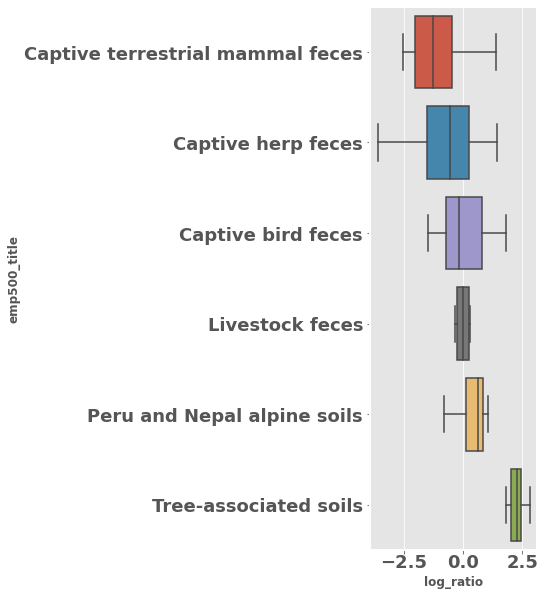

In [318]:

fig, ax = plt.subplots(1,1, figsize=(3, 10))

use_titles = ['Captive terrestrial mammal feces', 'Captive herp feces',
              'Captive bird feces','Livestock feces',  'Peru and Nepal alpine soils',
              'Tree-associated soils']

nonsal_metadata_emp500_plot = nonsal_metadata_emp500[nonsal_metadata_emp500.emp500_title.isin(use_titles)]
order_ = nonsal_metadata_emp500_plot.groupby('emp500_title').mean().sort_values('log_ratio').index
sns.boxplot(x='log_ratio', y='emp500_title', data=nonsal_metadata_emp500_plot, showfliers=False, order=order_)
plt.show()




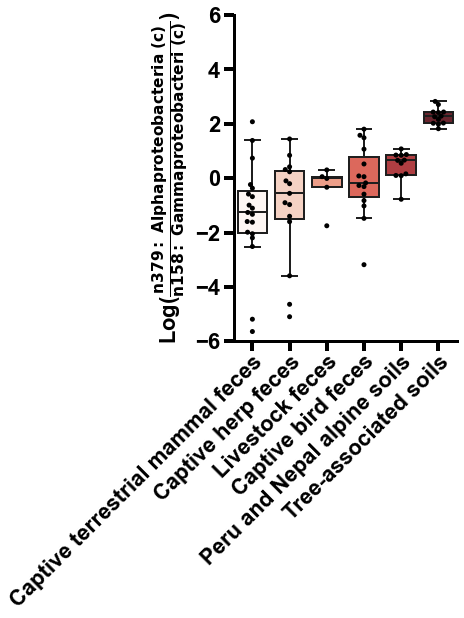

In [342]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

from itertools import combinations
from scipy.stats import ttest_ind


use_titles = ['Captive terrestrial mammal feces', 'Captive herp feces',
              'Captive bird feces','Livestock feces',  'Peru and Nepal alpine soils',
              'Tree-associated soils']

nonsal_metadata_emp500_plot = nonsal_metadata_emp500[nonsal_metadata_emp500.emp500_title.isin(use_titles)].drop(['13114.minich.76.s002'])
order_ = nonsal_metadata_emp500_plot.groupby('emp500_title').mean().sort_values('log_ratio').index


from matplotlib.pyplot import cm

color = cm.Reds(np.linspace(0, 1, len(order_)))
pal_ = {i:c for i, c in zip(order_, color)}

#pal_ = {'Checherta':'#1f78b4', 'Iquitos':'#a6cee3', 'Manaus':'#ff7f00'}

label_ = 'Log($\\frac{\mathrm{n379:\,\,Alphaproteobacteria\,\,(c)}}{\mathrm{n158:\,\,Gammaproteobacteri\,\,(c)}}$)'

fig, ax = plt.subplots(1,1, figsize=(4,6))

y_ = 'log_ratio'
x_ = 'emp500_title'
order_map = {v:i for i, v in enumerate(order_)}
#order_ = ['Checherta', 'Iquitos', 'Manaus']
lrdf_plot = nonsal_metadata_emp500_plot.dropna(subset=[y_]).copy()

t_res = {}
lrs_ds = {ds_:dsdf_[y_].values for ds_, dsdf_ in lrdf_plot.groupby(x_)}
#comobos = [('Checherta', 'Iquitos'), ('Manaus', 'Iquitos'), ('Manaus','Checherta')]
comobos = list(combinations(order_, 2))
for c1, c2 in comobos:
    t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
    t_res[(c1, c2)] =  t_stat, p_
t_resdf = pd.DataFrame(t_res).T
order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

sns.swarmplot(y=y_, x=x_, 
              data=lrdf_plot, 
              color='black',
              order=order_,
              s=5,
              ax=ax)
sns.boxplot(y=y_, x=x_, 
              data=lrdf_plot,
              palette=pal_,
              order=order_,
             ax=ax, linewidth=2, showfliers=False)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
ax.set_ylim(-6, 6)

ax.set_ylabel(label_,
              fontsize=22,
              family = 'arial',
              weight='bold',
              color='black')
ax.set_xlabel('',
              fontsize=18,
              family = 'arial',
              weight='bold',
              color='black')


"""for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
    #max_ = []
    #vals_ = [v[y_].dropna().values for k,v in lrdf_plot.groupby('disease_severity')]
    #stat_, p_ = ttest_ind(vals_[0], vals_[1])
    #x1, x2 = 0, 1
    #y, h, col = lrdf_plot[y_].max() + 0.5, .25, 'k'
    y, h, col = (i_v  * 2) + 2.9, .2, 'k'
    ax.plot([x1, x1, x2, x2],
             [y, y+h, y+h, y],
             lw=1.5, c=col)
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:3] + p_[p_.index('e'):]
        #p_ = "N=%i\nT=%.1f\nP=%s" % (lrdf_plot.shape[0],stat_,p_)
        p_ = "T=%.1f\nP=%s" % (stat_, p_)
    else:
        #p_ = "N=%i\nT=%.1f\nP=%.4f" % (lrdf_plot.shape[0],stat_,p_)
        p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
    ax.text((x1+x2)*.5, y+h,
             p_, ha='center',fontsize=12,
             va='bottom', color=col)"""

"""plt.savefig('../results/figures/FigS1Av2.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
"""
plt.show()

In [341]:
nonsal_metadata_emp500_plot[nonsal_metadata_emp500_plot[x_] == 'Livestock feces'].sort_values('log_ratio')


,sample_name_original,barcode_prefix,sample_type,emp500_shotgun_assembly_sample_name,gcms_sample_name,gcms_sequence,gcms_analysis_batch,gcms_run_location,lcms_sample_name_fbmn,lcms_sample_name_cmn,...,alpha_lcms_fbmn_microbial_richness,alpha_lcms_fbmn_microbial_noSingletons_richness,alpha_gcms_filt50_shannon,alpha_gcms_filt50_richness,songbird_trainTest_5050_empo_3,songbird_trainTest_5050_env_material,songbird_trainTest_8020_empo_3,songbird_trainTest_8020_env_material,songbird_trainTest_8020_empo_4,log_ratio
sample_name,,,,,,,,,,,,,,,,,,,,,
13114.minich.76.s001,Minich76.BM,minich.76.s001,stool,fecal_livestock,EMP_Feces_minich_76_s001_a03_M_261,261,note applicable,UCSD,5A8_2_31_minich-76-s001-a04.mzML,5A8_2_31_minich-76-s001-a04,...,3404,3404,5.319381879392148,185,Train,Test,Train,Train,Train,-1.750907
13114.minich.76.s005,Minich76.PM,minich.76.s005,stool,fecal_livestock,EMP_Feces_minich_76_s005_a03_M_265,265,note applicable,UCSD,5B4_2_78_minich-76-s005-a04.mzML,5B4_2_78_minich-76-s005-a04,...,3713,3713,5.372527330042201,189,Train,Train,Train,Test,Test,-0.333364
13114.minich.76.s006,Minich76.QM,minich.76.s006,stool,fecal_livestock,EMP_Feces_minich_76_s006_a03_M_266,266,note applicable,UCSD,5B3_2_71_minich-76-s006-a04.mzML,5B3_2_71_minich-76-s006-a04,...,3373,3373,5.030047148020321,185,Test,Train,Train,Test,Test,-0.009170
13114.minich.76.s004,Minich76.LM,minich.76.s004,stool,fecal_livestock,EMP_Feces_minich_76_s004_a03_M_264,264,note applicable,UCSD,5A11_2_63_minich-76-s004-a04.mzML,5A11_2_63_minich-76-s004-a04,...,3560,3560,5.473763807756795,185,Test,Train,Train,Train,Train,0.056103
13114.minich.76.s003,Minich76.GM,minich.76.s003,stool,fecal_livestock,EMP_Feces_minich_76_s003_a03_M_263,263,note applicable,UCSD,5A7_2_26_minich-76-s003-a04.mzML,5A7_2_26_minich-76-s003-a04,...,3743,3743,4.7485095868580505,179,Train,Test,Train,Train,Train,0.303993
13114.minich.76.s002,Minich76.CM,minich.76.s002,stool,fecal_livestock,EMP_Feces_minich_76_s002_a03_M_262,262,note applicable,UCSD,5B2_2_66_minich-76-s002-a04.mzML,5B2_2_66_minich-76-s002-a04,...,3784,3784,5.442348197227648,183,Test,Test,Train,Train,Train,2.615887


In [315]:
set(nonsal_metadata_emp500.emp500_title)

{'Active layer soil',
 'Animas watershed',
 'Bioreactors for wastewater and anammox',
 'Captive bird feces',
 'Captive herp feces',
 'Captive terrestrial mammal feces',
 'Centralia soil',
 'Coal and coal-associated water',
 'Costa Rican leaf-cutter ant and bee material',
 'Franz Josef Land glacier soils and water',
 'Hyporheic sediment',
 'Livestock feces',
 'Michigan forest lichen',
 'Mongolia soils (NSF PIRE)',
 'Mouse decomposition soil',
 'Namibia gravel plain gradient soils',
 'Oregon soils',
 'Permafrost soil',
 'Peru and Nepal alpine soils',
 'Pitcher plant fluids',
 'Postglacial pond sediment profiles',
 "Puhimau Hawai'i volcanic soil",
 'Singapore plant-associated soils',
 'Tree-associated soils',
 'West Texas playa'}

In [303]:
nonsal_metadata_emp500[nonsal_metadata_emp500.empo_2 == 'Animal'].emp500_title.value_counts()

Chernobyl vole feces                94
Captive terrestrial mammal feces    19
Captive herp feces                  15
Captive bird feces                  15
Rumen animals and bioreactor         9
Livestock feces                      6
Mouse decomposition skin             3
Captive aquatic mammal feces         3
Name: emp500_title, dtype: int64

In [302]:
nonsal_metadata_emp500[nonsal_metadata_emp500.empo_2 == 'Animal'].T.head(50)

sample_name,13114.angenent.65.s001,13114.angenent.65.s002,13114.angenent.65.s005,13114.angenent.65.s006,13114.angenent.65.s007,13114.metcalf.81.s001,13114.metcalf.81.s002,13114.metcalf.81.s003,13114.minich.76.s001,13114.minich.76.s002,...,13114.song.53.s013,13114.song.53.s014,13114.song.53.s015,13114.song.75.s002,13114.song.75.s003,13114.song.75.s004,13114.angenent.65.s003,13114.angenent.65.s004,13114.angenent.65.s008,13114.angenent.65.s009
sample_name_original,Angenent65.misc.104,Angenent65.misc.519,Angenent65.misc.1538,Angenent65.misc.1622,Angenent65.misc.1722,Metcalf81.10141.D.skin.body.T4.1,Metcalf81.10141.F.skin.body.T4.1,Metcalf81.10141.G.skin.body.T4.1,Minich76.BM,Minich76.CM,...,Song53.24657,Song53.25014,Song53.25069,Song75.24535,Song75.ace,Song75.myakka,Angenent65.misc.946,Angenent65.misc.1022,Angenent65.misc.1818,Angenent65.misc.1888
barcode_prefix,angenent.65.s001,angenent.65.s002,angenent.65.s005,angenent.65.s006,angenent.65.s007,metcalf.81.s001,metcalf.81.s002,metcalf.81.s003,minich.76.s001,minich.76.s002,...,song.53.s013,song.53.s014,song.53.s015,song.75.s002,song.75.s003,song.75.s004,angenent.65.s003,angenent.65.s004,angenent.65.s008,angenent.65.s009
sample_type,bioreactor sludge,bioreactor sludge,bioreactor sludge,bioreactor sludge,bioreactor sludge,skin,skin,skin,stool,stool,...,stool,stool,stool,stool,stool,stool,bioreactor sludge,bioreactor sludge,bioreactor sludge,bioreactor sludge
emp500_shotgun_assembly_sample_name,bioreactor_rumen,bioreactor_rumen,bioreactor_rumen,bioreactor_rumen,bioreactor_rumen,fecal_terrestrial_mammals_and_herps_and_tissue...,fecal_terrestrial_mammals_and_herps_and_tissue...,fecal_terrestrial_mammals_and_herps_and_tissue...,fecal_livestock,fecal_livestock,...,fecal_birds,fecal_birds,fecal_birds,fecal_aquatic_mammals,fecal_aquatic_mammals,fecal_aquatic_mammals,bioreactor_rumen,bioreactor_rumen,bioreactor_rumen,bioreactor_rumen
gcms_sample_name,EMP_Feces_angenent_65_s001_a03_M_185,EMP_Feces_angenent_65_s002_a03_M_186,EMP_Feces_angenent_65_s005_a03_M_187,EMP_Feces_angenent_65_s006_a03_M_188,EMP_Feces_angenent_65_s007_a03_M_189,EMP_Feces_metcalf_81_s001_a03_M_267,EMP_Feces_metcalf_81_s002_a03_M_268,EMP_Feces_metcalf_81_s003_a03_M_269,EMP_Feces_minich_76_s001_a03_M_261,EMP_Feces_minich_76_s002_a03_M_262,...,EMP_Feces_song_53_s013_a03_M_176,EMP_Feces_song_53_s014_a03_M_177,EMP_Feces_song_53_s015_a03_M_178,EMP_Feces_song_75_s002_a03_M_253,EMP_Feces_song_75_s003_a03_M_254,EMP_Feces_song_75_s004_a03_M_255,not applicable,not applicable,not applicable,not applicable
gcms_sequence,185,186,187,188,189,267,268,269,261,262,...,176,177,178,253,254,255,not applicable,not applicable,not applicable,not applicable
gcms_analysis_batch,note applicable,note applicable,note applicable,note applicable,note applicable,note applicable,note applicable,note applicable,note applicable,note applicable,...,note applicable,note applicable,note applicable,note applicable,note applicable,note applicable,not applicable,not applicable,not applicable,not applicable
gcms_run_location,UCSD,UCSD,UCSD,UCSD,UCSD,UCSD,UCSD,UCSD,UCSD,UCSD,...,UCSD,UCSD,UCSD,UCSD,UCSD,UCSD,not applicable,not applicable,not applicable,not applicable
lcms_sample_name_fbmn,5A1_2_2_angenent-65-s001-a04.mzML,5A3_2_9_angenent-65-s002-a04.mzML,5A6_2_19_angenent-65-s005-a04.mzML,5A4_2_14_angenent-65-s006-a04.mzML,5A2_2_3_angenent-65-s007-a04.mzML,5A10_2_52_metcalf-81-s001-a04.mzML,5A9_2_40_metcalf-81-s002-a04.mzML,5B1_2_64_metcalf-81-s003-a04.mzML,5A8_2_31_minich-76-s001-a04.mzML,5B2_2_66_minich-76-s002-a04.mzML,...,7A3_8_3_song-53-s013-a04.mzML,7D11_8_40_song-53-s014-a04.mzML,7E5_8_45_song-53-s015-a04.mzML,7D1_8_32_song-75-s002-a04.mzML,7F10_8_60_song-75-s003-a04.mzML,7H12_9_1_song-75-s004-a04.mzML,not applicable,not applicable,not applicable,not applicable
lcms_sample_name_cmn,5A1_2_2_angenent-65-s001-a04,5A3_2_9_angenent-65-s002-a04,5A6_2_19_angenent-65-s005-a04,5A4_2_14_angenent-65-s006-a04,5A2_2_3_angenent-65-s007-a04,5A10_2_52_metcalf-81-s001-a04,

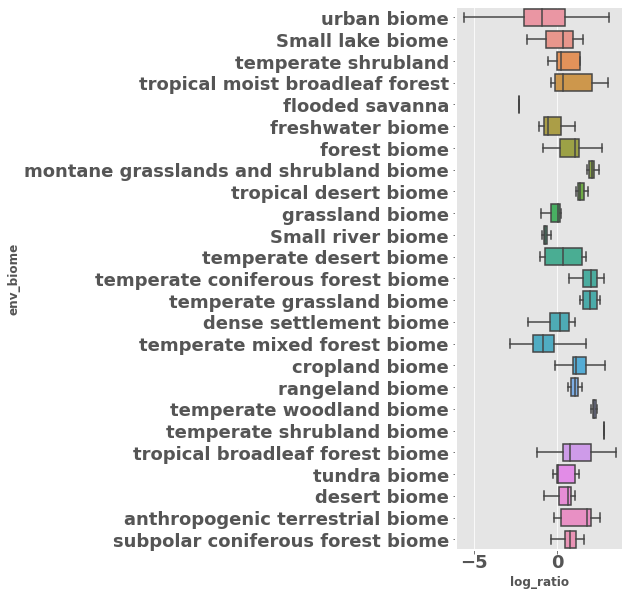

In [274]:
fig, ax = plt.subplots(1,1, figsize=(3, 10))

sns.boxplot(x='log_ratio', y='env_biome', data=nonsal_metadata_emp500, showfliers=False)

plt.show()



In [281]:
nonsal_metadata_emp500[nonsal_metadata_emp500.env_biome == 'urban biome'].sample_type.value_counts()

stool                 52
bioreactor biomass    17
bioreactor sludge      9
soil                   6
skin                   3
Name: sample_type, dtype: int64

In [246]:
metadata_emp500.columns


Index(['sample_name_original', 'barcode_prefix', 'sample_type',
       'emp500_shotgun_assembly_sample_name', 'gcms_sample_name',
       'gcms_sequence', 'gcms_analysis_batch', 'gcms_run_location',
       'lcms_sample_name_fbmn', 'lcms_sample_name_cmn', 'lcms_batch',
       'lcms_extraction_protocol', 'lcms_sample_type', 'lcms_sample_type_sub',
       'lcms_sampling_material', 'collection_timestamp', 'depth_sample',
       'depth_method', 'description', 'elevation',
       'emp500_principal_investigator', 'emp500_study_id',
       'emp500_pi_study_id', 'emp500_title', 'empo_0', 'empo_1', 'empo_2',
       'empo_3', 'empo_salinity', 'empo_v2_2', 'empo_v2_3a', 'empo_v2_3b',
       'empo_v2_4a', 'empo_v2_4b', 'empo_4', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'environmental_package', 'geo_loc_name',
       'host_subject_id', 'iron_mg_per_l', 'latitude', 'longitude',
       'project_name', 'scientific_name', 'read_count_shotgun_r1',
       'read_count_shotgun_woltka

'n20235'

array([-2.99763154e+00, -1.29266723e+00,  3.16066051e+00,  1.85575905e+00,
        6.32595273e-01,  9.93151124e-01, -3.52721328e-02,  1.32471130e+00,
        8.93817876e-01, -1.81518896e+00,  5.94198812e-01, -8.43117140e-01,
       -1.20827180e+00,  1.55840829e+00,  1.16410352e-01, -1.55155218e-02,
        1.41039724e+00, -5.28927369e-01, -3.88261785e-01, -2.97426111e-01,
        3.62110129e-01,  3.07308422e+00,  4.23066769e-01,  2.70122424e+00,
       -2.29112503e+00,  1.06080768e+00, -1.08532966e+00,  1.38725905e+00,
        2.19779942e-01,  3.46097710e+00,  3.92033726e+00,  4.35274881e+00,
        3.18921881e+00,  3.57405400e+00,  2.76757618e+00,  2.78943629e+00,
        2.12540494e+00,  4.46970534e+00,  2.96958162e+00,  2.57492011e+00,
        3.14528222e+00,  4.46324126e+00,  2.99669335e+00,  2.35194425e+00,
        9.03453585e-01,  4.35318071e-01,  1.19869575e+00,  9.06534557e-01,
        9.18819178e-01,  5.80558962e-01,  4.15204155e+00,  5.18697695e+00,
        4.31222840e+00,  

In [ ]:
tree_emp500.view()

In [ ]:
traversed_taxonomy_emp500 = retrieve_t2t_taxonomy(tree_emp500_tn, tax_emp500)
traversed_taxonomy_emp500_df = create_taxonomy_metadata(tree_emp500_tn, traversed_taxonomy_emp500)


In [183]:
fids_emp_upper = [f.upper() for f in fids_emp]

In [184]:

preorder_names = [n.name for n in tree_emp500.view(TreeNode).preorder()]
num_lca = ['c__Alphaproteobacteria' in traversed_taxonomy_emp500_df.loc[n, 'Taxon'] for n in preorder_names]
num_lca_node = preorder_names[num_lca.index(True)]

denom_lca = ['c__Betaproteobacteria' in traversed_taxonomy_emp500_df.loc[n, 'Taxon'] for n in preorder_names]
denom_lca_node = preorder_names[denom_lca.index(True)]



In [223]:
{k:v for k, v in tree_index_emp['id_index'].items() if 'n1640' == v.name}


{}

In [225]:
tree_index_emp['id_index']

{0: <TreeNode, name: G000830275, internal node count: 0, tips count: 0>,
 1: <TreeNode, name: G000402355, internal node count: 0, tips count: 0>,
 2: <TreeNode, name: G000830295, internal node count: 0, tips count: 0>,
 3: <TreeNode, name: G001871415, internal node count: 0, tips count: 0>,
 4: <TreeNode, name: N8, internal node count: 0, tips count: 2>,
 5: <TreeNode, name: N9, internal node count: 0, tips count: 2>,
 6: <TreeNode, name: G001940645, internal node count: 0, tips count: 0>,
 7: <TreeNode, name: G001940755, internal node count: 0, tips count: 0>,
 8: <TreeNode, name: G001940725, internal node count: 0, tips count: 0>,
 9: <TreeNode, name: G001563335, internal node count: 0, tips count: 0>,
 10: <TreeNode, name: G001940705, internal node count: 0, tips count: 0>,
 11: <TreeNode, name: G001563325, internal node count: 0, tips count: 0>,
 12: <TreeNode, name: N67, internal node count: 0, tips count: 2>,
 13: <TreeNode, name: G001940655, internal node count: 0, tips count: 0

In [215]:
traversed_taxonomy_emp500_df

,Taxon
Feature ID,
N1,k__; p__; c__; o__; f__; g__; s__
N2,k__Archaea; p__; c__; o__; f__; g__; s__
N4,k__Archaea; p__; c__; o__; f__; g__; s__
N8,k__Archaea; p__; c__; o__; f__; g__; s__
G000830275,k__Archaea; p__; c__; o__; f__; g__; s__
...,...
N6565,k__Bacteria; p__Proteobacteria; c__Epsilonprot...
G001830775,k__Bacteria; p__Proteobacteria; c__Epsilonprot...
N6990,k__Bacteria; p__Proteobacteria; c__Epsilonprot...


In [185]:
len(fids_emp)

9790

In [190]:
set(fids_emp_upper) - set([n.name for n in tree_emp500.view(TreeNode).preorder()])

{'N16264',
 'N15294',
 'N8338',
 'N12481',
 'N15601',
 'N11442',
 'N17812',
 'N16070',
 'N19715',
 'N20078',
 'N18978',
 'N18834',
 'N17435',
 'N11383',
 'N13177',
 'N13698',
 'N12924',
 'N13449',
 'N12729',
 'N13584',
 'N16986',
 'N13881',
 'N18733',
 'N17615',
 'N12172',
 'N14475',
 'N19767',
 'N20207',
 'N15901',
 'N17022',
 'N20595',
 'N14621',
 'N12992',
 'N17335',
 'N18161',
 'N10686',
 'N12911',
 'N19481',
 'N13753',
 'N15603',
 'N14534',
 'N15806',
 'N12521',
 'N12829',
 'N15729',
 'N17984',
 'N11311',
 'N15911',
 'N11868',
 'N12329',
 'N14364',
 'N16827',
 'N15879',
 'N17756',
 'N15083',
 'N12352',
 'N16349',
 'N12978',
 'N18942',
 'N12800',
 'N15628',
 'N13966',
 'N15261',
 'N19574',
 'N17670',
 'N16109',
 'N16310',
 'N14939',
 'N11709',
 'N16348',
 'N13955',
 'N15576',
 'N13764',
 'N17558',
 'N16589',
 'N11375',
 'N15985',
 'N19600',
 'N15257',
 'N12138',
 'N19148',
 'N15746',
 'N13747',
 'N10929',
 'N13612',
 'N16253',
 'N13730',
 'N12830',
 'N15899',
 'N10961',
 'N17102',


In [177]:
len([n.name for n in tree_emp500.view(TreeNode).preorder()])

20603

In [191]:
tree_index_emp['id_index'][16264]

<TreeNode, name: n16264, internal node count: 2, tips count: 4>

In [160]:
fids_emp.index(num_lca_node.lower())


95

In [161]:
fids_emp.index(denom_lca_node.lower())


338

In [171]:
tree_emp500.view(TreeNode).find(denom_lca_node.lower())


MissingNodeError: Node n4598 is not in self

In [169]:
counts_by_node_emp[:, fids_emp.index(num_lca_node.lower())]

counts_by_node_emp[:, fids_emp.index(denom_lca_node.lower())]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,
         0,   2,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  33,   1,   1,   4,   0,   0,   0,   0,  32,
         7,  18,   0,   9,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         2,   0,   3,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  26,   0,   0,   0,   0,   2,
         0,   0,   0,   3,   5, 238, 430,   0, 127, 258,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [165]:
counts_by_node_emp.shape

(598, 9790)

In [158]:
fids_emp

['G900012635',
 'n62',
 'n65',
 'n67',
 'n98',
 'n101',
 'n103',
 'n105',
 'G001775955',
 'n144',
 'n147',
 'G001870125',
 'G000802205',
 'G000730285',
 'G000698785',
 'G001917965',
 'G000303155',
 'n155',
 'n156',
 'n157',
 'n158',
 'n159',
 'G000241145',
 'G000220175',
 'n187',
 'G000484975',
 'G001541925',
 'G001674955',
 'G000956175',
 'G000242875',
 'G000299395',
 'n200',
 'n201',
 'n202',
 'n203',
 'G000328945',
 'G000299365',
 'G000875775',
 'n207',
 'G000746745',
 'G000746765',
 'n211',
 'G000724145',
 'n213',
 'G000018465',
 'n215',
 'n216',
 'n217',
 'n218',
 'n219',
 'n220',
 'n221',
 'n222',
 'n224',
 'n226',
 'n228',
 'n230',
 'n232',
 'n233',
 'n234',
 'n236',
 'n237',
 'n238',
 'G001560465',
 'n516',
 'n520',
 'n524',
 'n526',
 'n528',
 'n530',
 'n532',
 'n535',
 'n537',
 'n539',
 'n541',
 'n542',
 'n544',
 'n545',
 'n546',
 'n548',
 'G001421185',
 'n738',
 'n740',
 'n755',
 'n758',
 'n765',
 'n769',
 'n771',
 'n773',
 'G000969945',
 'G000970065',
 'n964',
 'n966',
 'n96

In [140]:
['2','1','1','3'].index('1')

1

In [132]:
traversed_taxonomy_emp500_df


,Taxon
Feature ID,
N1,k__; p__; c__; o__; f__; g__; s__
N2,k__Archaea; p__; c__; o__; f__; g__; s__
N4,k__Archaea; p__; c__; o__; f__; g__; s__
N8,k__Archaea; p__; c__; o__; f__; g__; s__
G000830275,k__Archaea; p__; c__; o__; f__; g__; s__
...,...
N6565,k__Bacteria; p__Proteobacteria; c__Epsilonprot...
G001830775,k__Bacteria; p__Proteobacteria; c__Epsilonprot...
N6990,k__Bacteria; p__Proteobacteria; c__Epsilonprot...
